# NON-NEGATIVE SPARSE PCA VIA SEMI-DEFINITE PROGRAM

In this notebook, we are going to implement the solving method of Non-negative Sparse PCA that we developed in our research paper. Indeed, we will try to solve the relaxed optimisation problem (cf problem (2) in our research paper) in order to solve the former optimisation problem (cf problem (1) in our paper) as we have shown that the two problems are equivalent. 


In [32]:
# Importing libraries
import cvxpy as cp
from numpy import *
from math import *

In [40]:
# Inputs
d= input('--> ') # input an integer
n= input('--> ') # input an integer
n=int(n)
d=int(d)

--> 500
--> 10000


In [42]:
def scalarproduct (X,Y) : 
    return transpose(X).dot(Y)

## Reproducing the "Spiked Covariance Model" in the Data 

Let us note that we have assumed we are under a "spiked covariance model". 
To reproduce this model in the data, let us assume that each observation X(i) follows the 
same probability distribution than X where : X=(v⊤Y)v + Z where : v⊤ is the transpose of v, Z can be seen as a noise, (v⊤Y)v is the orthogonal projection of Y on the vector space spanned by v, Z and Y are random vectors with d rows and 1 column, Z is independent of Y, E(Z)=0,E(ZZ⊤)=Id. So, we are now under a "spiked covariance model" as E(X)=ρvv⊤+Id where ρ=E((v⊤Y)^2).

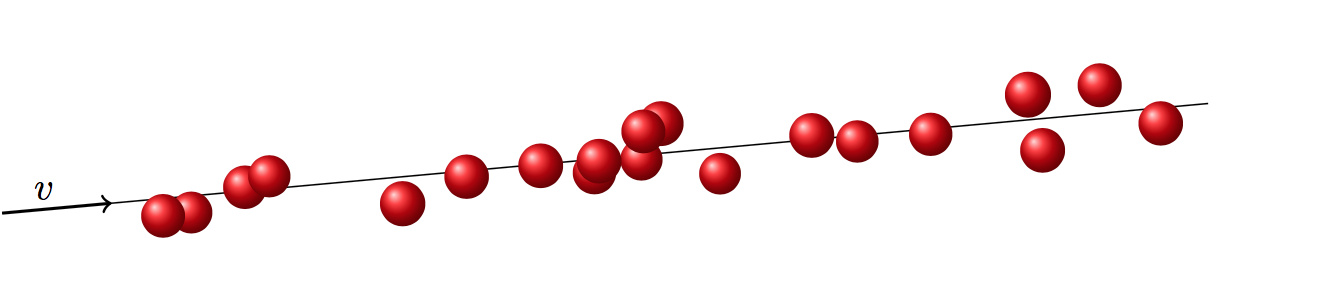

In [36]:
from IPython.display import Image
Image(filename="/Users/aaronmamann/Desktop/ENSAE/spcovmodel.png",width=600,height=400)

## Algorithm n°1 : 

Here is the first algorithm which solves Non-negative Sparse PCA with a good computational complexity. In order to test the algorithm n°1, let us choose a specific vector v (v=(1/k,...,1/k,0,...,0)) whose first k components are equal to 1/k. 
Let us observe that we have chosen a sparse vector v with non-negative components whose sum is equal to 1 as in our optimisation problem the solution has to be sparse, with non-negative components whose sum is equal to 1 (cf Introduction of our research paper). As a result, comparing v with the solution of our optimisation problem (found with our algorithm) is a good way to see if our algorithm works well. 

Let us assume that : Z↪Nd(0,id)(gaussian vector whose length is d), Y↪Nd(0,id), so : v⊤Y↪N(0,1)(gaussian variable). 
We have also that, the (X(i)) (i ∈ [[1,n]]) are i.i.d. and have the same distribution than X (and it is the same for the (Z(i)) and (Y(i)) respectively with Z and Y).

In [43]:
# Coding E(1 X)⊗(1 X) : 

k=input('--> ')
k=int(k)

v=ones((d,1))
E=zeros((d,1))
v[k:,0]=E[k:,0]
v=(1/k)*v

A=zeros((d+1,d+1)) 
for l in range (0,n):   
    C=A
    Y=random.randn(d)
    Z=random.randn(d)
    A[1:,0]=(transpose(v).dot(Y))*v[:,0]+Z
    A[0,1:]= transpose(A[1:,0])    
    A[1:,1:]=A[1:,0].dot(A[0,1:])
    A =C+A 
A= A*(1/n)
A[0,0]=1


--> 250


In [44]:
# Resolving the optimisation problem with CVXPY : 

# Writing the variable and the constraints

M = cp.Variable((d+1,d+1), PSD= True )
constraints=[M[0,0]==1,cp.sum(M[0,1:])==1,M>=zeros((d+1,d+1))]
constraints+=[cp.sum(M[1:,i+1])==M[0,i+1] for i in range (0,d)]

# Resolving the problem and printing the results

prob = cp.Problem(cp.Minimize(- cp.trace(A@M)),constraints)

# The Minimum of the objective function is 
result = prob.solve()
print ("The minimum of the objective function is ",result)
# The Argmin is 
print("The Argmin is ",M.value)




--> 5
The minimum of the objective function is  3.8881920063651565
The Argmin is  [[ 1.00000137e+00  8.36829464e-03  2.33918228e-06 ...  2.33691827e-04
   5.72783043e-03  3.67084672e-06]
 [ 8.36829464e-03  2.22221409e-04 -2.21532935e-10 ...  2.75316464e-07
   4.60611085e-05  2.90615012e-10]
 [ 2.33918228e-06 -2.21532935e-10  2.18645318e-07 ...  2.74438908e-10
   3.69886575e-09  5.32757080e-10]
 ...
 [ 2.33691827e-04  2.75316464e-07  2.74438908e-10 ...  1.01996148e-04
   3.45909007e-07 -2.04471251e-09]
 [ 5.72783043e-03  4.60611085e-05  3.69886575e-09 ...  3.45909007e-07
   1.05721499e-04  9.21640922e-09]
 [ 3.67084672e-06  2.90615012e-10  5.32757080e-10 ... -2.04471251e-09
   9.21640922e-09  4.02189449e-07]]


In [45]:
# comparing v with the solution of our optimisation 
# problem (found with our algorithm) to see if our algorithm works well.

print(sqrt(scalarproduct(M.value[1:,0]-v[:,0],M.value[1:,0]-v[:,0])))




0.06974348966590992


### As we are in this algorithm under the "spiked covariance model", we was expecting the solution of this algorithm to be a close estimation of v, and the result above (0.06974348) has shown us that the solution of this algorithm is good estimation of v. Therefore, it proves the algorithm n°1 works well. 


## Algorithm n°2 (Burer-Monteiro)

Here is the second algorithm which aims to solve Non-negative Sparse PCA. It has used the 
Burer-Monteiro factorisation to solve the optimisation problem. Indeed, the Burer-Monteiro method turns out to be useful as regards SDP(SEMI-DEFINITE PROGRAM) as it allows to solve the problem in a polynomial time. 

It consists in setting M=Y Y^T (where Y^T is the transpose of Y and Y has d+1 rows and p columns). Despite the fact that with the Burer-Monteiro method the optimisation problem becomes quadratic and nonconvex, Boumal et al. (cf References in our paper) showed when the optimisation search space is compact, the method provably solves generic equality-constrained SDP's when p > sqrt{2m}, where m is the number of constraints and p the number of Y's columns. 

Burer and Monteiro showed that if Y is a rank-deficient (which is the case) local optimum, then M=Y Y^T is a global optimum. Therefore, in the algorithm n°2, we are going to search for the Y local minimizers.

### The reason why we can't simulate this algorihtm n°2 entirely (and display the results) is due to the fact they are still some little mistakes to correct namely some operations which strongly increase the computational complexity. 

In [ ]:
# Importing libraries : 
from __future__ import division, print_function, absolute_import
import math
import scipy.linalg
import matplotlib
matplotlib.use('Agg')
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from matplotlib import rc
rc('text', usetex=True)

### You can direcly solve the problem by simulating this compartment. However, the result will be not satisfactory as you won't give a good initial guess (x0). Indeed, the results depend very much on your initial guess x0. In order to have a good initial guess, we have developed an algorithm in the following compartments. 

In [ ]:
n= input('--> ') # the number of observations, input an integer
n=int(n)

# We define the objective function 
def obj_function(A,Yv,k,d):# 
    # Coding E(1 X)⊗(1 X), 
    Y=_vector_to_matrix(Yv, k,d)
    # the number of R's columns (k) has to be strictly greater than sqrt{2m} where m is the number of constraints
    # that is why we have chosen here k=floor(sqrt(2*(2*d+2+2*(d+1)^2))+1)
    objective = -np.trace(-np.dot(np.array(A),np.dot(Y,np.transpose(Y)))) 
    return objective


# We write the Gradient vector of the objective function
def _gradient (A,Yv,k,d):
    Y=_vector_to_matrix(Yv, k,d)
    G= np.zeros((d+1,k))
    G[1:,:]=-2*np.dot(np.transpose(A[1:,1:]),Y[1:,:])
    G=np.reshape(G,(1,-1))
    return G  

# We define these functions to avoid the problem as regards Size Compatibility
def _matrix_to_vector(R):
    u = np.reshape(R,(1, -1))
    return u
def _vector_to_matrix(Rv,k,d):
    U = np.reshape(Rv,(d+1, k))
    return U


# We define the functions of the constraints of the optimisation problem
def constraint1 (Rv,d,k) :
    R=_vector_to_matrix(Rv, k,d)
    return R.dot(np.transpose(R))[0,0]-1
def constraint2 (Rv,k,d) : 
    R=_vector_to_matrix(Rv, k,d)
    return sum(R.dot(np.transpose(R))[0,1:])-1
def constraint3(Rv,k,d) : 
    R=_vector_to_matrix(Rv, k,d)
    cstr=sum(R.dot(np.transpose(R))[1:,i])-R.dot(np.transpose(R))[0,i]
    return cstr
def constraint4(Rv,k,d): 
    return 0   
def constraint5 (Rv,k,d):
    R=_vector_to_matrix(Rv, k,d)
    cst=R.dot(np.transpose(R))[i,j]
    return cst   
# Therefore, here are the constraints of the optimisation problem
cons=({'type': 'eq', 'fun':constraint1},{'type': 'eq', 'fun':constraint2})
for i in range (1,d+1):
    cons= cons + ({'type': 'eq', 'fun': constraint3},{'type': 'eq', 'fun': constraint4})
for i in range (0,d+1):
    for j in range (0,d) : 
        cons = cons + ({'type': 'eq', 'fun': constraint3},{'type': 'ineq', 'fun': constraint5})

        
# Thus, here is the function which will give you the local minimizers. 
# However, the results depend very much on your initial guess (x0), so we have to simulate this function
# after we have some information for the local minizers in order to have a good first guess x0
def optimizer_bm(x0):
   
    optimizer = opt.minimize(obj_function, x0,jac=_gradient, constraints=cons, method="SLSQP",options={'disp': True})
    return optimizer


### The  function below gives a result object which contains information of the local minimizer   in order to have a good first guess x0, we have to simulate the function "trust_region" (below) in this compartment which requires several algorithm like algorithms which uses conjugate gradient methods. 

In [ ]:
def trust_region(A,k,d, plotting=False, printing=False, init=None):
    
    print('Starting trust region on manifold...')
    if init is None:
        Y = _generate_random_rect(d, k)
    else:
        Y = init
    a = minimize_with_trust(lambda Yv: obj_function(A, Yv, d, k), Y, k,d, plotting, printing, jac=lambda Yv: _proj_grad_from_vec(
        A, Yv, d, k), hessp=lambda Yv, Tv: _hessian_p(A, Tv, d, k))
    # Here let us note that A=E(1 X)⊗(1 X) 
    return a 
 

### The function above requires all the functions and classes used below. 

In [ ]:
def minimize_with_trust(fun, x0, n_col,d, plotting, printing, args=(), jac=None, hess=None,
                        hessp=None, correlation_arr=None, curvature_arr=None, ground_truth=None, observation=None, callback=None, options=None):
    if options is None:
        options = {}
    return _minimize_trust_ncg(fun, x0, n_col,d, plotting, printing, args, jac, hess, hessp,
                               callback=callback, **options, correlation_arr=correlation_arr, curvature_arr=curvature_arr,
                               ground_truth=ground_truth, observation=observation)


In [ ]:
"""
Newton-CG trust-region optimization.
"""


def _minimize_trust_ncg(fun, x0, n_col,d, plotting, printing, args=(), jac=None, hess=None, hessp=None,
  **trust_region_options):
    return _minimize_trust_region(fun, x0, n_col,d, plotting, printing, args=args, jac=jac, hess=hess,
                                  hessp=hessp, subproblem=CGSteihaugSubproblem,
                                  **trust_region_options)

In [ ]:
def _minimize_trust_region(fun, x0, n_col,d, plotting, printing, args=(), jac=None, hess=None, hessp=None,
                           subproblem=None, initial_trust_radius=1.0,
                           max_trust_radius=1000.0, eta=0.15, gtol=1e-4,
                           maxiter=None, disp=False, return_all=False,
                           callback=None, **unknown_options):
    """
    Minimization of scalar function of one or more variables using a
    trust-region algorithm.
    Options for the trust-region algorithm are:
        initial_trust_radius : float
            Initial trust radius.
        max_trust_radius : float
            Never propose steps that are longer than this value.
        eta : float
            Trust region related acceptance stringency for proposed steps.
        gtol : float
            Gradient norm must be less than `gtol`
            before successful termination.
        maxiter : int
            Maximum number of iterations to perform.
        disp : bool
            If True, print convergence message.
    This function is called by the `minimize` function.
    It is not supposed to be called directly.
    """
    _check_unknown_options(unknown_options)

    # force the initial guess into a nice format
    x0 = np.asarray(x0).flatten()

    # Wrap the functions, for a couple reasons.
    # This tracks how many times they have been called
    # and it automatically passes the args.
    nfun, fun = wrap_function(fun, args)
    njac, jac = wrap_function(jac, args)
    nhess, hess = wrap_function(hess, args)
    nhessp, hessp = wrap_function(hessp, args)

    # limit the number of iterations
    if maxiter is None:
        maxiter = len(x0) * 2000

    # init the search status
    warnflag = 0

    # initialize the search
    trust_radius = initial_trust_radius
    x = x0
    if return_all:
        allvecs = [x]
    m = subproblem(x, fun, jac, hess, hessp)
    k = 0

    # search for the function min
    while True:

        # Solve the sub-problem.
        # This gives us the proposed step relative to the current position
        # and it tells us whether the proposed step
        # has reached the trust region boundary or not.
        try:
            p, hits_boundary = m.solve(trust_radius)
        except np.linalg.linalg.LinAlgError as e:
            warnflag = 3
            break

        # calculate the predicted value at the proposed point
        predicted_value = m(p)

        # define the local approximation at the proposed point
        # retract the point x from tangent space to the manifold
        if printing == True:
            print('Start retracting onto the manifold...')
        if n_col is not 1:
            x_proposed = _retraction(x + p,d)
        else:
            x_proposed = x + p
        m_proposed = subproblem(x_proposed, fun, jac, hess, hessp)

        # evaluate the ratio defined in equation (4.4)
        actual_reduction = m.fun - m_proposed.fun
        predicted_reduction = m.fun - predicted_value
        # if predicted_reduction <= 0:
        #     warnflag = 2
        #     break
        rho = actual_reduction / predicted_reduction

        # update the trust radius according to the actual/predicted ratio
        if rho < 0.25:
            trust_radius *= 0.25
        elif rho > 0.75 and hits_boundary:
            trust_radius = min(2 * trust_radius, max_trust_radius)

        # if the ratio is high enough then accept the proposed step
        if rho > eta:
            x = x_proposed
            m = m_proposed
            if printing == True:
                print('Proposed step accepted...')
            R = _vector_to_matrix(x, n_col,d)
            if plotting == True:
                _plot_Y(R)


        # append the best guess, call back, increment the iteration count
        if return_all:
            allvecs.append(x)
        if callback is not None:
            callback(x)
        k += 1

        # check if the gradient is small enough to stop
        if m.jac_mag < gtol:
            warnflag = 0
            break

        # check if we have looked at enough iterations
        if k >= maxiter:
            warnflag = 1
            break

    # print some stuff if requested
    status_messages = (
        _status_message['success'],
        _status_message['maxiter'],
        'A bad approximation caused failure to predict improvement.',
        'A linalg error occurred, such as a non-psd Hessian.',
    )
    if warnflag == 0:
        print(status_messages[warnflag])
    else:
        print('Warning: ' + status_messages[warnflag])
    # print("         Current function value: %f" % m())
    print("         Iterations: %d" % k)
    print("         Function evaluations: %d" % nfun[0])
    print("         Gradient evaluations: %d" % njac[0])
    if hessp is not None:
        print("         Hessian evaluations: %d" % nhessp[0])
    else:
        print("         Hessian evaluations: %d" % nhess[0])

    result = Result(x=x, success=(warnflag == 0), status=warnflag, fun=m.fun,
                    jac=m.jac, nfev=nfun[0], njev=njac[0], nhev=nhessp[0],
                    nit=k, message=status_messages[warnflag])

    if hess is not None:
        result['hess'] = m.hess

    if return_all:
        result['allvecs'] = allvecs

    return result


In [ ]:
# Some intermediate functions :

# For the initialization of the random matrix.    
def _generate_random_rect(d, k):
    Y = np.random.uniform(0, 1, (d+1,k))
    while cnst(Y,d,k) !=d and np.sum(np.dot(Y,np.transpose(Y))[0, 1:]) != 1 and np.dot(Y,np.transpose(Y))[0,0] !=1 : 
        Y = np.random.uniform(0, 1, (d+1,k))
    return Y 
def cnst(Y,d,k) :
    V=0
    for i in range (0,d) : 
        if np.sum(np.dot(Y,np.transpose(Y))[1:,i+1])==np.dot(Y,np.transpose(Y))[0,i+1] :
            V=V+1
    return V

# This function returns projected point from tangent plane back to the manifold.    
def _projection(Z, Y):
    dia = np.diag(np.diag(Z.dot(Y.T)))
    return Z - np.dot(dia,Y)

# It calculates the gradient of the objective function without reshaping it into a vector. 
def _grad(A, Y,k,d):
    G=np.zeros((d+1,k))
    G[1:,:]=-2*np.dot(np.transpose(A[1:,1:]),Y[1:,:])
    return G 
 
# In order to plot the found matrices Y on their row vectors.
def _plot_Y(Y):
    plt.style.use('ggplot')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.scatter(Y.T[0], Y.T[1], alpha=0.25, label='Rows of R')
    plt.legend()
    plt.show()

# It calculates the projected gradient given point on manifold in vector form.
def _proj_grad_from_vec(A, Yv, d, k):
    Y = _vector_to_matrix(Yv, k,d)
    proj_grad = _projection(_grad(A, Y,k,d), Y)
    return _matrix_to_vector(proj_grad)

# This function returns the directional Hessian matrix.
def _hessian_p(A, Tv, d, k):
    Tv=np.reshape(Tv,(-1,1))
    H=np.zeros(((d+1)^2,k^2))
    H=np.reshape(H,((d+1)^2,k^2))
    A=np.reshape(H,(d+1,d+1))
    for l in range (1,d+1):
        for u in range (0,k):
            H[(d+1)*l +1:(d+1)*(l+1),k*u+u]=-2*A[1:d+1,l]
    return _matrix_to_vector(np.dot(H,Tv))

# It calculates the retracted point given one on the tangent plane.
def _retraction(Tv,d):
    T = _vector_to_matrix(Tv, 2,d)
    T=np.reshape(T,(d+1,-1))
    for i in range(d+1):
        T[i, :] = T[i, :] / np.linalg.norm(T[i, :])
    return _matrix_to_vector(T)

def _check_unknown_options(unknown_options):
    if unknown_options:
        msg = ", ".join(map(str, unknown_options.keys()))
        # Stack level 4: this is called from _minimize_*, which is
        # called from another function in Scipy. Level 4 is the first
        # level in user code.
        # warnings.warn("Unknown solver options: %s" % msg, OptimizeWarning, 4)


# We wrap the functions after for a couple reasons.
# This tracks how many times they have been called
# and it automatically passes the args.
def wrap_function(function, args):
    ncalls = [0]
    if function is None:
        return ncalls, None

    def function_wrapper(*wrapper_args):
        ncalls[0] += 1
        return function(*(wrapper_args + args))

    return ncalls, function_wrapper

_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.'}


In [ ]:
class CGSteihaugSubproblem(BaseQuadraticSubproblem):
    """
        Quadratic subproblem solved by a conjugate gradient method
        """

    def solve(self, trust_radius):
        """
        Solve the subproblem using a conjugate gradient method.
        Parameters
        ----------
        trust_radius : float
            We are allowed to wander only this far away from the origin.
        Returns
        -------
        p : ndarray
            The proposed step.
        hits_boundary : bool
            True if the proposed step is on the boundary of the trust region.
        Notes
        -----
        This is algorithm (7.2) of Nocedal and Wright 2nd edition.
        Only the function that computes the Hessian-vector product is required.
        The Hessian itself is not required, and the Hessian does
        not need to be positive semidefinite.
        """

        # get the norm of jacobian and define the origin
        p_origin = np.zeros_like(self.jac)

        # define a default tolerance
        tolerance = min(0.5, math.sqrt(self.jac_mag)) * self.jac_mag

        # Stop the method if the search direction
        # is a direction of nonpositive curvature.
        if self.jac_mag < tolerance:
            hits_boundary = False
            return p_origin, hits_boundary

        # init the state for the first iteration
        z = p_origin
        r = self.jac
        v = -r

        # Search for the min of the approximation of the objective function.
        while True:

            # do an iteration
            Bv = self.hessp(v)
            vBv = np.dot(v, Bv)
            if vBv <= 0:
                # Look at the two boundary points.
                # Find both values of t to get the boundary points such that
                # ||z + t v|| == trust_radius
                # and then choose the one with the predicted min value.
                ta, tb = self.get_boundaries_intersections(z, v, trust_radius)
                pa = z + ta * v
                pb = z + tb * v
                if self(pa) < self(pb):
                    p_boundary = pa
                else:
                    p_boundary = pb
                hits_boundary = True
                return p_boundary, hits_boundary
            r_squared = np.dot(r, r)
            alpha = r_squared / vBv
            z_next = z + alpha * v
            if scipy.linalg.norm(z_next) >= trust_radius:
                # Find t >= 0 to get the boundary point such that
                # ||z + t v|| == trust_radius
                ta, tb = self.get_boundaries_intersections(z, v, trust_radius)
                p_boundary = z + tb * v
                hits_boundary = True
                return p_boundary, hits_boundary
            r_next = r + alpha * Bv
            r_next_squared = np.dot(r_next, r_next)
            if math.sqrt(r_next_squared) < tolerance:
                hits_boundary = False
                return z_next, hits_boundary
            beta_next = r_next_squared / r_squared
            v_next = -r_next + beta_next * v

            # update the state for the next iteration
            z = z_next
            r = r_next
            v = v_next

In [ ]:
class Result(dict):
    """ Represents the optimization result.
    Attributes
    ----------
    x : ndarray
        The solution of the optimization.
    success : bool
        Whether or not the optimizer exited successfully.
    status : int
        Termination status of the optimizer. Its value depends on the
        underlying solver. Refer to `message` for details.
    message : str
        Description of the cause of the termination.
    fun, jac, hess, hess_inv : ndarray
        Values of objective function, Jacobian, Hessian or its inverse (if
        available). The Hessians may be approximations, see the documentation
        of the function in question.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
    nit : int
        Number of iterations performed by the optimizer.
    maxcv : float
        The maximum constraint violation.
    Notes
    -----
    There may be additional attributes not listed above depending of the
    specific solver. Since this class is essentially a subclass of dict
    with attribute accessors, one can see which attributes are available
    using the `keys()` method.
    """

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in self.items()])
        else:
            return self.__class__.__name__ + "()"


__all__ = []

In [ ]:
class BaseQuadraticSubproblem(object):
    """
    Base/abstract class defining the quadratic model for trust-region
    minimization. Child classes must implement the ``solve`` method.
    Values of the objective function, jacobian and hessian (if provided) at
    the current iterate ``x`` are evaluated on demand and then stored as
    attributes ``fun``, ``jac``, ``hess``.
    """

    def __init__(self, x, fun, jac, hess=None, hessp=None):
        self._x = x
        self._f = None
        self._g = None
        self._h = None
        self._g_mag = None
        self._cauchy_point = None
        self._newton_point = None
        self._fun = fun
        self._jac = jac
        self._hess = hess
        self._hessp = hessp

    def __call__(self, p):
        return self.fun + np.dot(self.jac, p) + 0.5 * np.dot(p, self.hessp(p))

    @property
    def fun(self):
        """
        Value of objective function at current iteration.
        """
        if self._f is None:
            self._f = self._fun(self._x)
        return self._f

    @property
    def jac(self):
        """
        Value of jacobian of objective function at current iteration.
        """
        if self._g is None:
            self._g = self._jac(self._x)
        return self._g

    @property
    def hess(self):
        """
        Value of hessian of objective function at current iteration.
        """
        if self._h is None:
            self._h = self._hess(self._x)
        return self._h

    def hessp(self, p):
        if self._hessp is not None:
            return self._hessp(self._x, p)
        else:
            return np.dot(self.hess, p)

    @property
    def jac_mag(self):
        """
        Magniture of jacobian of objective function at current iteration.
        """
        if self._g_mag is None:
            self._g_mag = scipy.linalg.norm(self.jac)
        return self._g_mag

    def get_boundaries_intersections(self, z, h, trust_radius):
        """
        Solve the scalar quadratic equation ||z + th|| == trust_radius.
        This is like a line-sphere intersection.
        Return the two values of t, sorted from low to high.
        """
        a = np.dot(h, h)
        b = 2 * np.dot(z, h)
        c = np.dot(z, z) - trust_radius**2
        sqrt_discriminant = math.sqrt(b * b - 4 * a * c)
        ta = (-b - sqrt_discriminant) / (2 * a)
        tb = (-b + sqrt_discriminant) / (2 * a)
        return ta, tb

    def solve(self, trust_radius):
        raise NotImplementedError('The solve method should be implemented by '
                                  'the child class')